In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from PIL import Image
import os

# Tentukan folder sumber dan tujuan
source_folder = '/content/drive/My Drive/folder_sumber'  # Ganti dengan lokasi folder di Drive
destination_folder = '/content/drive/My Drive/folder_tujuan'

# Buat folder tujuan jika belum ada
os.makedirs(destination_folder, exist_ok=True)

# Fungsi untuk memproses gambar
def process_images(source, destination):
    for filename in os.listdir(source):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            # Baca gambar
            image_path = os.path.join(source, filename)
            img = Image.open(image_path)

            # Konversi ke grayscale
            img = img.convert('L')

            # Crop dan ubah ukuran ke 48x48
            img = img.resize((48, 48))

            # Simpan ke folder tujuan
            save_path = os.path.join(destination, filename)
            img.save(save_path)
            print(f"Processed: {filename}")

# Jalankan pemrosesan
process_images(source_folder, destination_folder)


In [ ]:
import os
import shutil
import random

# Direktori dataset awal
original_dir_dasi = "/content/drive/MyDrive/DATASET SERAGAM/DATASET UTAMA/JUSTDASI/dasi"
original_dir_tanpa_dasi = "/content/drive/MyDrive/DATASET SERAGAM/DATASET UTAMA/JUSTDASI/tanpa dasi"

# Direktori output
base_dir = "/content/drive/MyDrive/DATASET SERAGAM/DATASET UTAMA/JUSTDASI/split"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Membuat folder train, val, dan test untuk kedua kelas
for subset in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(subset, "dasi"), exist_ok=True)
    os.makedirs(os.path.join(subset, "tanpa_dasi"), exist_ok=True)

# Fungsi untuk membagi dataset
def split_dataset(original_dir, train_dir, val_dir, test_dir, split_ratio=(0.8, 0.1, 0.1)):
    # List semua file
    files = os.listdir(original_dir)
    random.shuffle(files)  # Acak file

    # Hitung jumlah file untuk setiap subset
    train_split = int(split_ratio[0] * len(files))
    val_split = int(split_ratio[1] * len(files))

    # Bagi dataset
    train_files = files[:train_split]
    val_files = files[train_split:train_split + val_split]
    test_files = files[train_split + val_split:]

    # Pindahkan file ke folder masing-masing
    for file in train_files:
        shutil.copy(os.path.join(original_dir, file), os.path.join(train_dir, file))
    for file in val_files:
        shutil.copy(os.path.join(original_dir, file), os.path.join(val_dir, file))
    for file in test_files:
        shutil.copy(os.path.join(original_dir, file), os.path.join(test_dir, file))

# Bagi dataset untuk kelas dasi
split_dataset(original_dir_dasi, os.path.join(train_dir, "dasi"), os.path.join(val_dir, "dasi"), os.path.join(test_dir, "dasi"))

# Bagi dataset untuk kelas tanpa dasi
split_dataset(original_dir_tanpa_dasi, os.path.join(train_dir, "tanpa_dasi"), os.path.join(val_dir, "tanpa_dasi"), os.path.join(test_dir, "tanpa_dasi"))


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

In [ ]:
# Konfigurasi dataset dari Google Drive
train_dir = '/content/drive/MyDrive/DATASET SERAGAM/DATASET UTAMA/JUSTDASI/split/train'
val_dir = '/content/drive/MyDrive/DATASET SERAGAM/DATASET UTAMA/JUSTDASI/split/val'

In [ ]:
# Lihat isi folder
print(os.listdir(val_dir))
# Lihat isi folder
print(os.listdir(train_dir))

['dasi', 'tanpa_dasi']
['dasi', 'tanpa_dasi']


In [ ]:
# Data Augmentation untuk training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalisasi gambar ke rentang [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]  # Meningkatkan variasi gambar
)

# Data augmentation hanya untuk normalisasi pada validation set
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Memuat data dengan grayscale (1 saluran)
train_data = train_datagen.flow_from_directory(
    train_dir,
    color_mode='grayscale',  # Menetapkan mode warna grayscale
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary'  # Klasifikasi binary (dasi/sabuk vs tidak)
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    color_mode='grayscale',  # Menetapkan mode warna grayscale
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary'  # Klasifikasi binary (dasi/sabuk vs tidak)
)

Found 199 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Membangun model CNN yang lebih sederhana dengan beberapa perbaikan untuk menghindari overfitting
model = models.Sequential([
    layers.Input(shape=(128, 128, 1)),  # Input grayscale dengan dimensi 128x128 dan 1 saluran

    # Lapisan konvolusi pertama dengan Batch Normalization dan Dropout
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),  # Dropout setelah pooling

    # Lapisan konvolusi kedua dengan Batch Normalization dan Dropout
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),  # Dropout setelah pooling

    layers.Flatten(),

    # Dense layer dengan Dropout
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(1, activation='sigmoid')  # Output binary (dasi/sabuk vs tidak)
])


# Menyusun model dengan optimizer dan loss function yang sesuai
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Menampilkan ringkasan model
model.summary()

# Menggunakan EarlyStopping untuk menghentikan pelatihan jika validasi loss tidak membaik
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Melatih model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stopping]  # Menambahkan early stopping
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,705,729 (14.14 MB)

 Trainable params: 3,705,537 (14.14 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 5s/step - accuracy: 0.6130 - loss: 4.5592 - val_accuracy: 0.5000 - val_loss: 1.1064
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.8043 - loss: 3.3982 - val_accuracy: 0.5000 - val_loss: 0.7312
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8691 - loss: 1.3448 - val_accuracy: 0.9821 - val_loss: 0.3162
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9199 - loss: 0.2648 - val_accuracy: 0.8571 - val_loss: 0.3335
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.8775 - loss: 0.4601 - val_accuracy: 0.7143 - val_loss: 0.4448
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9358 - loss: 0.2208 - val_accuracy: 0.5179 - val_loss: 0.6540
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.9342 - loss: 0.3229 - val_accuracy: 0.5357 - val_loss: 0.6671
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9013 - loss: 0.2482 - val_accuracy: 0.6429 - val_loss: 0.6521


In [ ]:
# Simpan model
model.save('my_model.keras')

In [ ]:
# Evaluasi model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Accuracy')

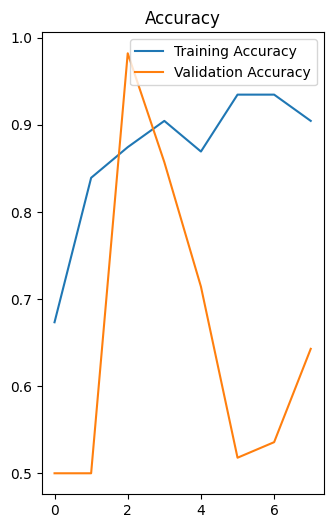

In [ ]:
# Plot hasil
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

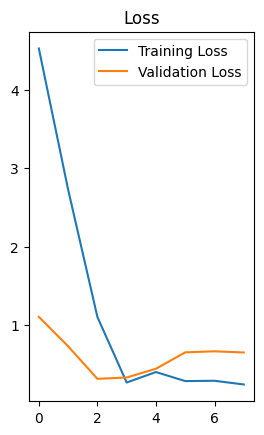

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
# Konfigurasi folder test
test_dir = '/content/drive/MyDrive/DATASET SERAGAM/DATASET UTAMA/JUSTDASI/split/test'  # Direktori test

# Data augmentation untuk test set (hanya normalisasi)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Memuat data test
test_data = test_datagen.flow_from_directory(
    test_dir,
    color_mode='grayscale',  # Sesuaikan dengan mode warna model (grayscale)
    target_size=(128, 128),  # Sesuaikan dengan ukuran input model
    batch_size=32,
    class_mode='binary',  # Klasifikasi binary
    shuffle=False  # Jangan shuffle agar urutan prediksi sesuai dengan urutan file
)

Found 54 images belonging to 2 classes.


In [ ]:
# Evaluasi model pada data test
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Membuat prediksi
predictions = model.predict(test_data)


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 1.0000 - loss: 0.3265
Test Accuracy: 100.00%
Test Loss: 0.2996
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step


In [ ]:
import numpy as np

# Ambil nama file dari data test
filenames = test_data.filenames

# Ambil prediksi dalam bentuk binary (1 untuk "dasi", 0 untuk "tidak dasi/sabuk")
predicted_classes = (predictions > 0.5).astype(int)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

# Menyiapkan test datagen untuk test set
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Memuat data test dengan batch_size 1 untuk memproses gambar satu per satu
test_data = test_datagen.flow_from_directory(
    test_dir,
    color_mode='grayscale',
    target_size=(128, 128),
    batch_size=1,  # Batch size 1 untuk memproses gambar per gambar
    class_mode='binary',  # Binary classification (dasi vs tidak berdasi)
    shuffle=False  # Jangan diacak agar urutannya konsisten
)

# Prediksi pada test set
predictions = model.predict(test_data, batch_size=32)

# Mengambil nama file gambar yang ada pada test set
filenames = test_data.filenames

# Mengonversi prediksi (nilai probabilitas) ke dalam label kelas (0 atau 1)
predicted_classes = (predictions > 0.5).astype("int32")

# Menampilkan 10 prediksi pertama beserta gambar yang sesuai
for i in range(54):
    img = image.load_img(test_dir + '/' + filenames[i], target_size=(128, 128), color_mode='grayscale')
    plt.imshow(img, cmap='gray')  # Menampilkan gambar dalam mode grayscale
    plt.title(f"File: {filenames[i]} - Predicted: {'Dasi' if predicted_classes[i][0] == 0 else 'Tidak Dasi'}")
    plt.axis('off')  # Menonaktifkan sumbu
    plt.show()


54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step


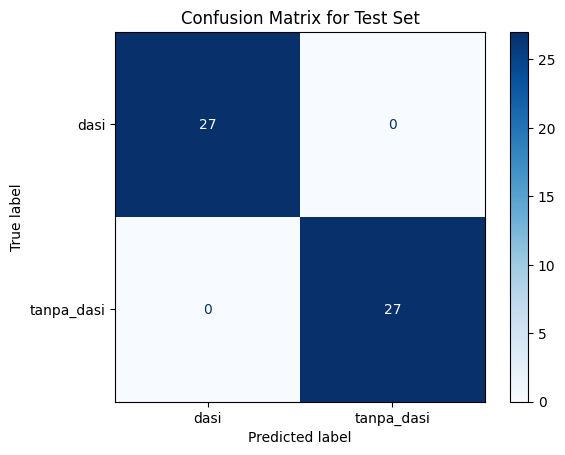

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Mengambil prediksi untuk test set
test_data.reset()  # Reset generator test_data
predictions = model.predict(test_data)
predicted_classes = (predictions > 0.5).astype(int)  # Mengonversi probabilitas ke kelas (0 atau 1)

# Mengambil label asli
true_classes = test_data.classes  # Label asli dari test set
class_labels = list(test_data.class_indices.keys())  # Label kelas ('dasi', 'tidak berdasi')

# Membuat confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Menampilkan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Set')
plt.show()
